In [19]:
# !pip install catboost
# !pip install optuna

In [20]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import joblib
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from catboost import Pool
from sklearn.model_selection import KFold
from xgboost import DMatrix


# Đảm bảo thư mục 'model' tồn tại
if not os.path.exists('model'):
    os.makedirs('model')

# Đọc dữ liệu từ file CSV
dataset = pd.read_csv('./data/train.csv')


dataset['Diameter_to_Height_Ratio'] = dataset['Diameter'] / dataset['Height']
dataset['Combined_Whole_Weight'] = dataset['Whole weight'] + dataset['Whole weight.1'] + dataset['Whole weight.2']
dataset['Diameter_Length_Product'] = dataset['Diameter'] * dataset['Length']
sex_mapping = {'M': 0, 'F': 1, 'I': 2}
dataset['Sex'] = dataset['Sex'].map(sex_mapping)
dataset['Shell_Volume'] = (4/3) * 3.14 * (dataset['Diameter'] / 2)**2 * dataset['Height']
dataset['Shell_Surface_Area'] = 4 * 3.14 * (dataset['Diameter'] / 2)**2
dataset['Shell_Density'] = dataset['Shell weight'] / dataset['Shell_Volume']
dataset['Shell_Thickness'] = dataset['Height'] - dataset['Diameter']
dataset['Shell_Shape_Index'] = dataset['Shell_Surface_Area'] / dataset['Shell_Volume']
dataset['Length_to_Height_Ratio'] = dataset['Length'] / dataset['Height']







In [21]:
dataset.sample(5).style.background_gradient()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Diameter_to_Height_Ratio,Combined_Whole_Weight,Diameter_Length_Product,Shell_Volume,Shell_Surface_Area,Shell_Density,Shell_Thickness,Shell_Shape_Index,Length_to_Height_Ratio
42297,42297,0,0.600000,0.475000,0.160000,1.177500,0.563500,0.256500,0.310000,10,2.968750,1.997500,0.285000,0.037785,0.708462,8.204386,-0.315000,18.750000,3.750000
80056,80056,0,0.545000,0.415000,0.160000,0.974000,0.339500,0.229500,0.295000,24,2.593750,1.543000,0.226175,0.028842,0.540786,10.228158,-0.255000,18.750000,3.406250
20890,20890,2,0.385000,0.290000,0.100000,0.252000,0.106000,0.050000,0.080000,7,2.900000,0.408000,0.111650,0.008802,0.264074,9.088362,-0.190000,30.000000,3.850000
47438,47438,0,0.505000,0.400000,0.130000,0.717500,0.276000,0.155000,0.193000,10,3.076923,1.148500,0.202000,0.021771,0.502400,8.865140,-0.270000,23.076923,3.884615
15566,15566,1,0.665000,0.525000,0.165000,1.390500,0.664500,0.265500,0.368500,10,3.181818,2.320500,0.349125,0.047600,0.865463,7.741525,-0.360000,18.181818,4.030303


In [22]:
unique_counts = dataset.nunique()
#Threshold to distinguish continous and categorical
threshold = 12
continuous_vars_temp = unique_counts[unique_counts > threshold].index.tolist()
#categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()
if 'id' in continuous_vars_temp:
    continuous_vars_temp.remove('id')
numerical_columns = dataset.select_dtypes(include='number').columns
def remove_outliers_replace(data, columns, threshold=1.5):
    data_no_outliers = data.copy()

    for column in columns:
        Q1 = data_no_outliers[column].quantile(0.25)
        Q3 = data_no_outliers[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        is_outlier = (data_no_outliers[column] < lower_bound) | (data_no_outliers[column] > upper_bound)

        if data_no_outliers[column].dtype == 'O':  # Categorical column
            median_value = data_no_outliers.loc[~is_outlier, column].mode().iloc[0]
            data_no_outliers.loc[is_outlier, column] = median_value
        else:  # Numerical column
            mean_value = data_no_outliers.loc[~is_outlier, column].mean()
            data_no_outliers.loc[is_outlier, column] = mean_value

    return data_no_outliers

columns_to_remove_outliers_replace = continuous_vars_temp
dataset = remove_outliers_replace(dataset, columns_to_remove_outliers_replace)

C:\Users\tient\AppData\Local\Temp\ipykernel_17204\61665388.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.206054894569442' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_no_outliers.loc[is_outlier, column] = mean_value


In [23]:
dataset.drop(columns='id',axis = 1,inplace = True)

X = dataset.drop(columns='Rings', axis=1).values
y = dataset['Rings'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train the catboost

In [24]:

best_params_cat ={'learning_rate': 0.07855075323884125, 'n_estimators': 489, 'max_depth': 7,
                  'subsample': 0.8569934338945397, 'colsample_bylevel': 0.8150591618201379,
                  'reg_lambda': 0.4264547280178772}
model_cat = CatBoostRegressor(**best_params_cat)
model_cat.fit(X, y)


0:	learn: 2.1803957	total: 24.9ms	remaining: 12.2s
1:	learn: 2.0989485	total: 50.3ms	remaining: 12.3s
2:	learn: 2.0274560	total: 74.4ms	remaining: 12s
3:	learn: 1.9611921	total: 97.6ms	remaining: 11.8s
4:	learn: 1.9030736	total: 119ms	remaining: 11.5s
5:	learn: 1.8528826	total: 142ms	remaining: 11.4s
6:	learn: 1.8086199	total: 167ms	remaining: 11.5s
7:	learn: 1.7700117	total: 189ms	remaining: 11.3s
8:	learn: 1.7353992	total: 210ms	remaining: 11.2s
9:	learn: 1.7051385	total: 233ms	remaining: 11.2s
10:	learn: 1.6792953	total: 254ms	remaining: 11s
11:	learn: 1.6555172	total: 276ms	remaining: 11s
12:	learn: 1.6348259	total: 304ms	remaining: 11.1s
13:	learn: 1.6172711	total: 323ms	remaining: 10.9s
14:	learn: 1.6017384	total: 342ms	remaining: 10.8s
15:	learn: 1.5868754	total: 364ms	remaining: 10.8s
16:	learn: 1.5754867	total: 385ms	remaining: 10.7s
17:	learn: 1.5640679	total: 407ms	remaining: 10.7s
18:	learn: 1.5551171	total: 429ms	remaining: 10.6s
19:	learn: 1.5469172	total: 449ms	remaining

In [25]:
model_cat.best_score_

{'learn': {'RMSE': 1.374952969660005}}

# Train the XGBoost

In [26]:
best_params = {'learning_rate': 0.02708319027879099, 'n_estimators': 495, 'reg_alpha': 0.14219650343206225,
               'reg_lambda': 0.5045620145662986, 'max_depth': 12, 'subsample': 0.9537603851451735,
               'colsample_bytree': 0.7819555259366398, 'min_child_weight': 1.03921704772634}
model_xgb = XGBRegressor(**best_params)
model_xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7819555259366398, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02708319027879099, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=1.03921704772634, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=495,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Prepare dataset

In [27]:
dataset_test = pd.read_csv('./data/test.csv')
y_test_cat = pd.read_csv("./data/prediction_catboost_abalone_age.csv").values
y_test_cat = y_test_cat[:,1]
y_test_xgb = pd.read_csv("./data/predictions_xg_abalone_age.csv").values
y_test_xgb = y_test_xgb[:,1]
dataset_test['Diameter_to_Height_Ratio'] = dataset_test['Diameter'] / dataset_test['Height']
dataset_test['Combined_Whole_Weight'] = dataset_test['Whole weight'] + dataset_test['Whole weight.1'] + dataset_test['Whole weight.2']
dataset_test['Diameter_Length_Product'] = dataset_test['Diameter'] * dataset_test['Length']
sex_mapping = {'M': 0, 'F': 1, 'I': 2}
dataset_test['Sex'] = dataset_test['Sex'].map(sex_mapping)
dataset_test['Shell_Volume'] = (4/3) * 3.14 * (dataset_test['Diameter'] / 2)**2 * dataset_test['Height']
dataset_test['Shell_Surface_Area'] = 4 * 3.14 * (dataset_test['Diameter'] / 2)**2
dataset_test['Shell_Density'] = dataset_test['Shell weight'] / dataset_test['Shell_Volume']
dataset_test['Shell_Thickness'] = dataset_test['Height'] - dataset_test['Diameter']
dataset_test['Shell_Shape_Index'] = dataset_test['Shell_Surface_Area'] / dataset_test['Shell_Volume']
dataset_test['Length_to_Height_Ratio'] = dataset_test['Length'] / dataset_test['Height']

X_test = dataset_test.drop(columns=['id'],axis = 1)
X_test = X_test.values


In [28]:
print(min(y_test_cat))
print(min(y_test_xgb))

8.454853496904176
9.017669


# Predict

## Catboost

In [29]:
# Dự đoán model catboost
predictions_cat = model_cat.predict(X_test)
print(predictions_cat)

[9.78859818 9.81144137 9.95077828 ... 9.70098719 9.9389736  9.73838865]


## XGBoost

In [30]:
# Dự đoán xgboost
score = model_xgb.score(X_test, y_test_xgb)
print("Score on data_test: " , score)
predictions_xgb = model_xgb.predict(X_test)
print(predictions_xgb)
rmse = np.sqrt(mean_squared_error(y_test_xgb, predictions_xgb))
print("RMSE:", rmse)

Score on data_test:  0.8943382159700393
[10.780516 10.817469 11.137207 ... 11.316094 10.36267  10.825015]
RMSE: 0.16947871255310043


# Display predict

In [31]:
results_cat = pd.DataFrame({
    'ID': dataset_test['id'],
    'Predicted Age': predictions_cat
})
# Lọc các giá trị Predicted Age lớn hơn 12
results_filtered = results_cat['Predicted Age']
min_value = min(results_filtered)
print("Giá trị nhỏ nhất là:", min_value)

# Hiển thị kết quả
print(results_filtered)

Giá trị nhỏ nhất là: 8.454853496904176
0        9.788598
1        9.811441
2        9.950778
3        9.964458
4        9.518189
           ...   
60406    9.313764
60407    9.354487
60408    9.700987
60409    9.938974
60410    9.738389
Name: Predicted Age, Length: 60411, dtype: float64


In [32]:
results_xgb = pd.DataFrame({
    'ID': dataset_test['id'],
    'Predicted Age': predictions_xgb
})
# Lọc các giá trị Predicted Age lớn hơn 12
results_filtered = results_xgb['Predicted Age']
min_value = min(results_filtered)
print("Giá trị nhỏ nhất là:", min_value)

# Hiển thị kết quả
print(results_filtered)

Giá trị nhỏ nhất là: 9.017668724060059
0        10.780516
1        10.817469
2        11.137207
3        11.123709
4        10.274329
           ...    
60406     9.796649
60407    10.814801
60408    11.316094
60409    10.362670
60410    10.825015
Name: Predicted Age, Length: 60411, dtype: float32


# Vẽ biểu đồ trực quan catboost

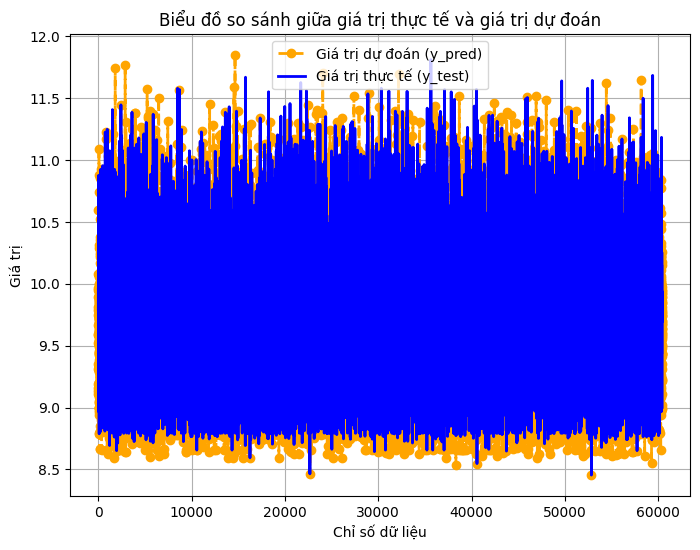

In [33]:
y_pred = predictions_cat
# Vẽ biểu đồ đường
plt.figure(figsize=(8, 6))

# Vẽ đường cho giá trị thực tế (y_test)
plt.plot(range(len(y_pred)), y_pred, color='orange', linestyle='--', linewidth=2, label='Giá trị dự đoán (y_pred)', marker='o')
plt.plot(range(len(y_test_cat)), y_test_cat, color='blue', linestyle='-', linewidth=2, label='Giá trị thực tế (y_test)')

# Vẽ đường cho giá trị dự đoán (y_pred)

# Đặt tên trục và tiêu đề
plt.xlabel('Chỉ số dữ liệu')
plt.ylabel('Giá trị')
plt.title('Biểu đồ so sánh giữa giá trị thực tế và giá trị dự đoán')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

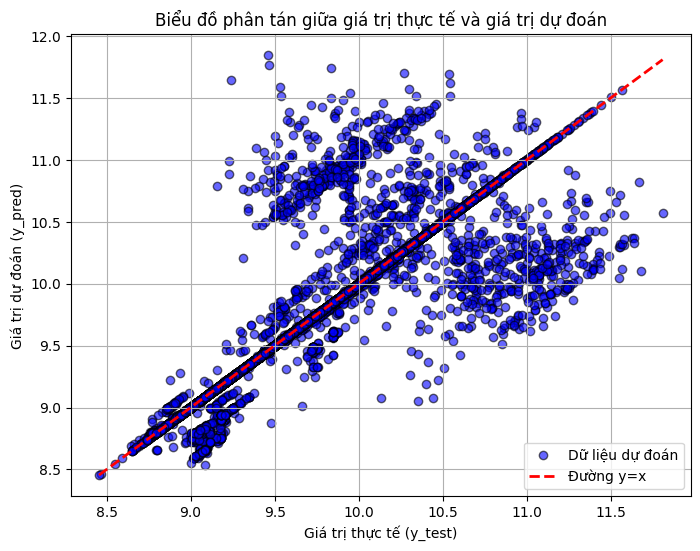

In [34]:
y_pred = predictions_cat

# Vẽ biểu đồ phân tán
plt.figure(figsize=(8, 6))
plt.scatter(y_test_cat, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Dữ liệu dự đoán')
plt.plot([min(y_test_cat), max(y_test_cat)], [min(y_test_cat), max(y_test_cat)], color='red', linestyle='--', linewidth=2, label='Đường y=x')

# Đặt tên trục và tiêu đề
plt.xlabel('Giá trị thực tế (y_test)')
plt.ylabel('Giá trị dự đoán (y_pred)')
plt.title('Biểu đồ phân tán giữa giá trị thực tế và giá trị dự đoán')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


# Vẽ biểu đồ trực quan xgboost

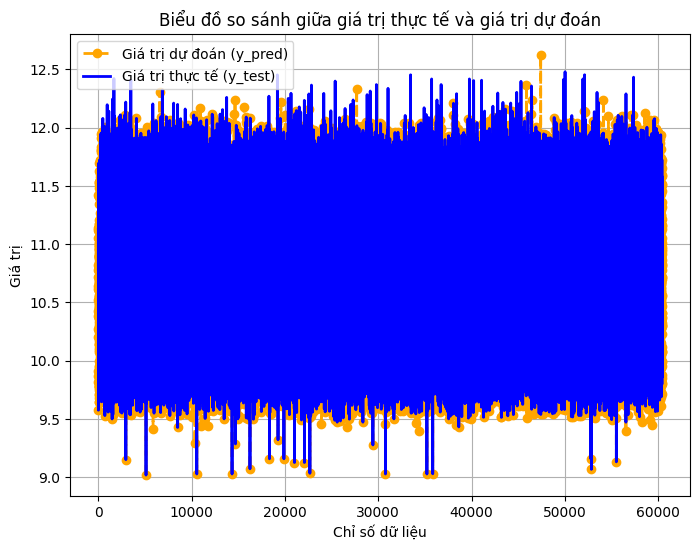

In [35]:
y_pred = predictions_xgb
# Vẽ biểu đồ đường
plt.figure(figsize=(8, 6))

# Vẽ đường cho giá trị thực tế (y_test)
plt.plot(range(len(y_pred)), y_pred, color='orange', linestyle='--', linewidth=2, label='Giá trị dự đoán (y_pred)', marker='o')
plt.plot(range(len(y_test_xgb)), y_test_xgb, color='blue', linestyle='-', linewidth=2, label='Giá trị thực tế (y_test)')

# Vẽ đường cho giá trị dự đoán (y_pred)

# Đặt tên trục và tiêu đề
plt.xlabel('Chỉ số dữ liệu')
plt.ylabel('Giá trị')
plt.title('Biểu đồ so sánh giữa giá trị thực tế và giá trị dự đoán')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

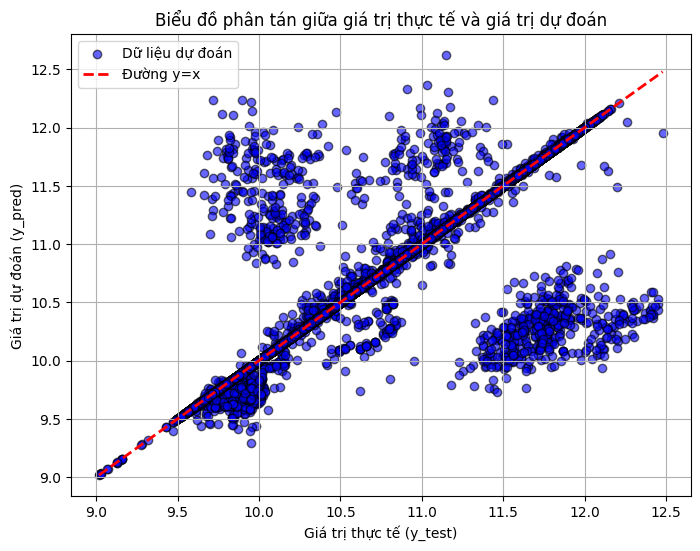

In [36]:
y_pred = predictions_xgb

# Vẽ biểu đồ phân tán
plt.figure(figsize=(8, 6))
plt.scatter(y_test_xgb, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Dữ liệu dự đoán')
plt.plot([min(y_test_xgb), max(y_test_xgb)], [min(y_test_xgb), max(y_test_xgb)], color='red', linestyle='--', linewidth=2, label='Đường y=x')

# Đặt tên trục và tiêu đề
plt.xlabel('Giá trị thực tế (y_test)')
plt.ylabel('Giá trị dự đoán (y_pred)')
plt.title('Biểu đồ phân tán giữa giá trị thực tế và giá trị dự đoán')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()